#### Off Policy DQN

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import gymnasium
from collections import deque
import matplotlib.pyplot as plt
tf.keras.utils.disable_interactive_logging()

2024-12-04 15:23:14.564602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 15:23:18.674551: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick/miniconda3/envs/tf_env/lib/python3.9/site-packages/nvidia/cudnn/lib:/home/nick/miniconda3/envs/tf_env/lib/
2024-12-04 15:23:18.674648: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
env = gymnasium.make("CartPole-v1")

In [4]:
input_shape = env.observation_space.shape[0]
n_outputs = env.action_space.n

q_net = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[input_shape]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target_net = keras.models.clone_model(q_net)
target_net.set_weights(q_net.get_weights())

In [5]:
replay_buffer = deque(maxlen=50000)
optimizer = keras.optimizers.Adam(learning_rate=6e-3)
discount_factor = 0.95
loss_fn = keras.losses.Huber()
batch_size=32
total_losses = []

In [6]:
def epsilon_greedy_policy(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    q_value = q_net.predict(state[np.newaxis])
    return np.argmax(q_value)

In [7]:
def collect_step(state, epsilon):
    action  = epsilon_greedy_policy(state, epsilon)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, done, reward

def train_step(batch_size):
    rnd_indices = np.random.randint(0, len(replay_buffer), batch_size)
    samples = [replay_buffer[index] for index in rnd_indices]
    states, actions, rewards, next_states, dones = [np.array([sample[field_index] for sample in samples]) for field_index in range(5)]

    target_q_values = q_net.predict(next_states)
    target_mask = tf.one_hot(np.argmax(target_q_values, axis=1), n_outputs).numpy()

    target_max_q_values = (target_net.predict(next_states) * target_mask).sum(axis=1)
    target_q_values = (rewards + target_max_q_values * discount_factor * (1 - dones))
    target_q_values = target_q_values.reshape(-1, 1)

    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        q_values = q_net(states)
        q_values = tf.reduce_sum(q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_q_values, q_values))
    grads = tape.gradient(loss, q_net.trainable_variables)
    optimizer.apply_gradients(zip(grads, q_net.trainable_variables))
    total_losses.append(loss)

    
    

In [8]:
total_rewards = []
for iteration in range(1500):
    state, _ = env.reset(seed=42)
    iteration_rewards = 0
    for step in range(200):
        epsilon = max(1 - iteration / 1400, 0.01)
        state, done, reward = collect_step(state, epsilon)
        iteration_rewards += reward
        if done:
            break
    total_rewards.append(iteration_rewards)
    print("\rIteration: {}, Steps: {}, eps: {:.3f}".format(iteration, step + 1, epsilon), end="")
    if iteration >= 50:
        train_step(batch_size)
        if iteration % 50 == 0:
            target_net.set_weights(q_net.get_weights())
        if iteration % 100 == 0:
            tf.keras.backend.clear_session()


Iteration: 50, Steps: 17, eps: 0.964WARNING:tensorflow:5 out of the last 5 calls to <function _BaseOptimizer._update_step_xla at 0x7f37b88bcf70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration: 1499, Steps: 112, eps: 0.010

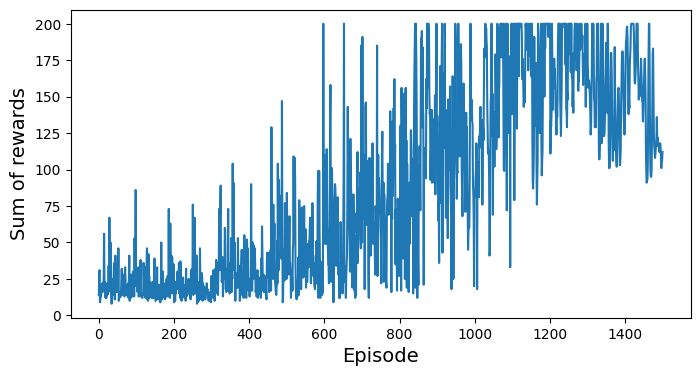

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(total_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

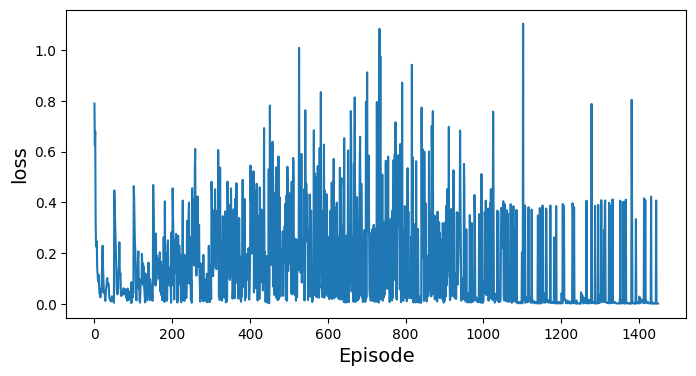

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(total_losses)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.show()